作業二我是使用範例稍做改造成簡單的cnn

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding

np.random.seed(10)

Using TensorFlow backend.


# 1.引入資料
從keras的datasets中拿取mnist的手寫數字資料來練習

In [2]:
from keras.datasets import mnist

In [3]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()
#將訓練資料分成X_train_image為input，y_train_label為訓練用output
#將測試資料分成X_test_image為input，y_test_label為需要預測的資料

print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape))) #看看兩邊的資料有多少，並同時看看圖片的shape
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))
print("\t[Info] Shape of test data=%s" % (str(X_test_image.shape))) #看看兩邊的資料有多少，並同時看看圖片的shape
print("\t[Info] Shape of test label=%s" % (str(y_test_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)
	[Info] Shape of test data=(10000, 28, 28)
	[Info] Shape of test label=(10000,)


從印出的Info可以看出總共有60000張圖可以拿來訓練，10000張圖需要預測，而圖的大小是28*28個pixel，且看起來是灰階，因為沒有第四個維度去紀錄RGB

# 2.看看內容和畫圖函式

In [4]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf() #選擇拿已有的圖來畫
    fig.set_size_inches(2, 2) #設置成大小為2吋 * 2吋(5.08 * 5.08 cm^2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

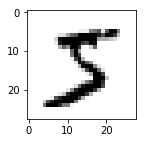

In [5]:
plot_image(X_train_image[0]) #試著畫出訓練資料的第一張圖

In [6]:
y_train_label[0] #印出第一張圖的label(答案)，比對一下

5

In [7]:
#畫圖時順便讓title帶有正確答案和預測值(如果有給預測值)
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14) 
    if num > 25: num = 25  #限定最多畫25張圖
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        if len(prediction) > i:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx])) #如果有預測值則印出帶有label和預測值(p)的title
        else:  
            title = "l={}".format(str(labels[idx])) #沒有預測值就指印出帶有label的title
        ax.set_title(title, fontsize=10) # 設置title的字體大小為10
        ax.set_xticks([]); ax.set_yticks([])  #設置讓他不顯示刻度(x軸和y軸不帶有數字)
        idx+=1  
    plt.show()

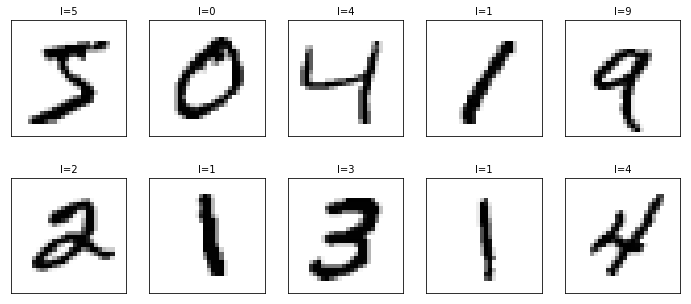

In [8]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0, 10) #試著使用看看，讓prediction為空陣列，title只印出label


# 3.資料預處理
將資料正規化，並多增加一個維度channel，且因為是灰階所以只需多增加一個維度，不需其它處理<br>

且將label做one-hot encoding的轉換

In [9]:

print("[Info] xTrain: %s" % (str(X_train_image.shape)))
print("[Info] xTest: %s" % (str(X_test_image.shape)))
  
# Normalization
x_Train_norm = X_train_image/255
print(x_Train_norm.max())# 確認有沒有成功使其介於0~1
print(x_Train_norm.min())
x_Test_norm = X_test_image/255

[Info] xTrain: (60000, 28, 28)
[Info] xTest: (10000, 28, 28)
1.0
0.0


In [10]:
x_Train_norm = x_Train_norm[:,:,:,np.newaxis]#為了能fit進Conv2d需要多加一個維度
x_Test_norm = x_Test_norm[:,:,:,np.newaxis]

In [11]:
#one-hot encoding的目的是讓分類也能用數字表示，如今天是估計值就不需要，且最後也不需要有softmax的activation function
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding 

y_train_label[0] # 檢視 training labels 第一個 label 的值
y_TrainOneHot[:1] # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# 4. 創建模型
選擇適當的layer、activation和loss function等等

In [12]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import Conv2D #引入以2維數據當input的卷積層
from keras.layers import Flatten #引入將多維壓扁成一維的層
model = Sequential()  # Build Linear Model  

model.add(Conv2D(filters=256, kernel_size=3,activation='relu', kernel_initializer='normal'))# Add Input/hidden layer
model.add(Flatten()) # 將前面Conv2D的多維filter壓扁，讓Dense層能接收
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax')) # Add Hidden/output layer  


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#選擇loss function和optimizer，錯誤率(分數)計算方式為準確度(accuracy)

# 5.開始訓練
- 將處理好的input(x_Train_norm)和正確答案輸入(y_TrainOneHot)
- 切割20%的訓練資料做為驗證資料(validation_split)
- 訓練10個回合(epochs)
- 每回合訓練200個image(batch_size)
- 顯示每回合的loss和準確度(verbose=2)
- 看看模型的整體計算量和神經元數

In [14]:
train_history = model.fit(x=x_Train_norm, 
                          y=y_TrainOneHot, 
                          validation_split=0.2, 
                          epochs=10, 
                          batch_size=200, 
                          verbose=2)

print("[Info] Model summary:")  
model.summary()  

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 108s - loss: 0.2333 - acc: 0.9302 - val_loss: 0.0905 - val_acc: 0.9762
Epoch 2/10
 - 15s - loss: 0.0692 - acc: 0.9807 - val_loss: 0.0705 - val_acc: 0.9795
Epoch 3/10
 - 15s - loss: 0.0440 - acc: 0.9868 - val_loss: 0.0754 - val_acc: 0.9779
Epoch 4/10
 - 15s - loss: 0.0303 - acc: 0.9907 - val_loss: 0.0719 - val_acc: 0.9793
Epoch 5/10
 - 15s - loss: 0.0217 - acc: 0.9941 - val_loss: 0.0786 - val_acc: 0.9789
Epoch 6/10
 - 16s - loss: 0.0159 - acc: 0.9958 - val_loss: 0.0730 - val_acc: 0.9808
Epoch 7/10
 - 16s - loss: 0.0120 - acc: 0.9970 - val_loss: 0.0794 - val_acc: 0.9785
Epoch 8/10
 - 16s - loss: 0.0094 - acc: 0.9977 - val_loss: 0.0766 - val_acc: 0.9808
Epoch 9/10
 - 16s - loss: 0.0057 - acc: 0.9987 - val_loss: 0.0838 - val_acc: 0.9801
Epoch 10/10
 - 16s - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0800 - val_acc: 0.9813
[Info] Model summary:
_________________________________________________________________
Layer (type)        

# 6.成果展示
將準確度和loss的變化畫出來

In [15]:
#建立畫圖的函式以重複使用
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

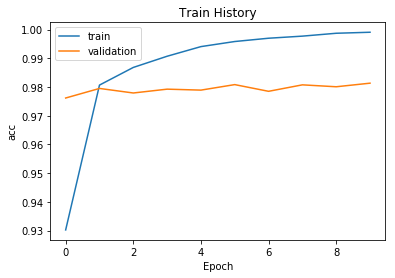

In [16]:
show_train_history(train_history, 'acc', 'val_acc')
#看看準確度在測試資料和訓練資料的變化

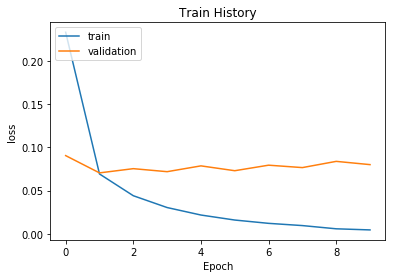

In [17]:
show_train_history(train_history, 'loss', 'val_loss')
#看看loss(類似錯誤率，所以愈低愈好)在測試資料和訓練資料的變化

In [18]:
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
#可以看到在測驗資料上準確度有不錯的數字

10000/10000 [==============================] - 2s 193us/step

	[Info] Accuracy of testing data = 98.3%


	[Info] Making prediction to x_Test_norm

	[Info] Show 10 prediction result (From 240):
[2 8 6 3 3 8 6 5 4 0]



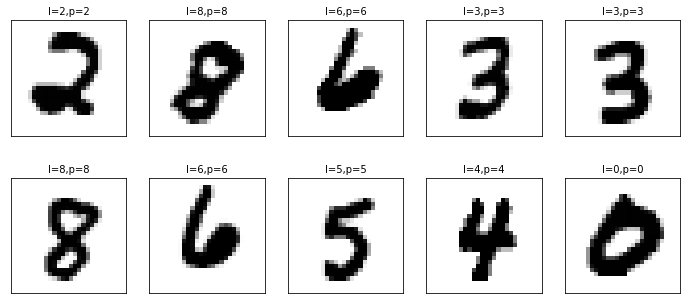

In [19]:
print("\t[Info] Making prediction to x_Test_norm")  
prediction = model.predict_classes(x_Test_norm)  # 做出預測，並且儲存起來
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
index = np.random.randint(0, len(prediction)-10) #因為要印出連續十組，隨機取0~長度-10的integer
print("%s\n" % (prediction[index:index+10]))  #印出10組預測值
plot_images_labels_predict(X_test_image, y_test_label, prediction, idx=index) #畫出10組圖